# 🧪 Model Testing & Evaluation Notebook

This notebook provides comprehensive testing and evaluation of all trained models in the codebase:
- **SegFormer** (Transformer-based segmentation)
- **U-Net EfficientNet** (CNN-based with EfficientNet backbone)
- **Pure ViT** (Vision Transformer segmentation)
- **DeepLabV3+ ResNet** (Multi-scale segmentation)

## 📋 Features:
- ✅ Load trained models from checkpoints
- ✅ Test inference on sample images
- ✅ Calculate performance metrics (Dice, Jaccard)
- ✅ Visualize predictions vs ground truth
- ✅ Compare model performance
- ✅ Robust error handling

## 🚀 Usage:
1. Run all cells in order
2. Models will be loaded automatically if available
3. Test images will be processed and results displayed
4. Performance comparison will be generated

## 📦 Import Dependencies

In [1]:
# Install required packages if not available
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install required packages
required_packages = [
    'torch', 'torchvision', 'transformers', 'timm', 
    'segmentation-models-pytorch', 'albumentations', 
    'opencv-python-headless', 'matplotlib', 'seaborn', 
    'scikit-learn', 'tqdm'
]

for package in required_packages:
    try:
        if package == 'opencv-python-headless':
            import cv2
        elif package == 'segmentation-models-pytorch':
            import segmentation_models_pytorch as smp
        else:
            __import__(package)
    except ImportError:
        print(f"⚠️  {package} not found, installing...")
        if package == 'segmentation-models-pytorch':
            subprocess.check_call([sys.executable, "-m", "pip", "install", "segmentation-models-pytorch"])
        else:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("✅ All required packages are available!")

⚠️  scikit-learn not found, installing...
✅ All required packages are available!


In [2]:
# Core imports
import os
import glob
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
import json
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Computer Vision
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ML Libraries
import timm
import segmentation_models_pytorch as smp
from transformers import (
    SegformerImageProcessor, SegformerForSemanticSegmentation,
    AutoImageProcessor, AutoModelForSemanticSegmentation
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Metrics
from sklearn.metrics import jaccard_score, accuracy_score
from tqdm.auto import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful!
🔥 PyTorch version: 2.8.0+cu128
🖥️  Device: CUDA
   GPU: NVIDIA GeForce RTX 5070 Ti
   Memory: 16.6 GB


## ⚙️ Configuration & Setup

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

# Paths configuration
MODELS_DIR = Path('models')
DATA_DIR = Path('data')
TEST_DATA_DIR = DATA_DIR / 'test'
VAL_DATA_DIR = DATA_DIR / 'val'

# Create directories if they don't exist
MODELS_DIR.mkdir(exist_ok=True)

# Model configurations
MODEL_CONFIGS = {
    'segformer': {
        'name': 'SegFormer',
        'description': 'Transformer-based segmentation',
        'checkpoint_pattern': 'segformer_model_*.pth',
        'params': '3.7M',
        'color': '#FF6B6B'
    },
    'unet_efficientnet': {
        'name': 'U-Net EfficientNet',
        'description': 'CNN-based with EfficientNet backbone',
        'checkpoint_pattern': 'unet_efficientnet_model_*.pth',
        'params': '5.3M',
        'color': '#4ECDC4'
    },
    'pure_vit': {
        'name': 'Pure ViT',
        'description': 'Vision Transformer segmentation',
        'checkpoint_pattern': 'pure_vit_model_*.pth',
        'params': '5M',
        'color': '#45B7D1'
    },
    'deeplabv3_resnet': {
        'name': 'DeepLabV3+ ResNet',
        'description': 'Multi-scale segmentation',
        'checkpoint_pattern': 'deeplabv3_resnet_model_*.pth',
        'params': '39.6M',
        'color': '#F7DC6F'
    }
}

# Check available models
available_models = {}
for model_key, config in MODEL_CONFIGS.items():
    pattern = str(MODELS_DIR / config['checkpoint_pattern'])
    checkpoints = glob.glob(pattern)
    if checkpoints:
        # Prefer 'best' checkpoint over 'final'
        best_checkpoint = None
        final_checkpoint = None
        
        for checkpoint in checkpoints:
            if 'best' in checkpoint:
                best_checkpoint = checkpoint
            elif 'final' in checkpoint:
                final_checkpoint = checkpoint
        
        selected_checkpoint = best_checkpoint or final_checkpoint
        if selected_checkpoint:
            available_models[model_key] = {
                'checkpoint': selected_checkpoint,
                'config': config
            }

print(f"\n📊 Found {len(available_models)} trained models:")
for model_key, model_info in available_models.items():
    config = model_info['config']
    checkpoint_name = Path(model_info['checkpoint']).name
    print(f"   ✅ {config['name']} ({config['params']}) - {checkpoint_name}")

if not available_models:
    print("⚠️  No trained models found! Please run training notebooks first.")
    print("   Expected model files in 'models/' directory:")
    for config in MODEL_CONFIGS.values():
        print(f"   - {config['checkpoint_pattern']}")

🖥️  Using device: cuda

📊 Found 4 trained models:
   ✅ SegFormer (3.7M) - segformer_model_best.pth
   ✅ U-Net EfficientNet (5.3M) - unet_efficientnet_model_best.pth
   ✅ Pure ViT (5M) - pure_vit_model_best.pth
   ✅ DeepLabV3+ ResNet (39.6M) - deeplabv3_resnet_model_best.pth


## 🏗️ Model Architecture Definitions

In [4]:
# SegFormer Model Class
class SegFormerModel(nn.Module):
    def __init__(self, model_name="nvidia/segformer-b0-finetuned-ade-512-512", num_classes=1):
        super().__init__()
        
        # Load pre-trained SegFormer
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
        # Image processor for preprocessing
        self.processor = SegformerImageProcessor.from_pretrained(model_name)
        
        print(f"✅ SegFormer model loaded: {model_name}")
        print(f"   - Number of classes: {num_classes}")
        print(f"   - Input size: 512x512")
    
    def forward(self, x):
        # SegFormer expects input in specific format
        outputs = self.segformer(pixel_values=x)
        logits = outputs.logits
        
        # Upsample to input resolution
        logits = F.interpolate(logits, size=x.shape[-2:], mode='bilinear', align_corners=False)
        
        # Apply sigmoid for binary segmentation
        return torch.sigmoid(logits)

# U-Net EfficientNet Model Class
class UNetEfficientNet(nn.Module):
    def __init__(self, backbone_name="efficientnet-b0", num_classes=1, pretrained=True):
        super().__init__()
        
        # Use segmentation_models_pytorch to create U-Net with EfficientNet backbone
        self.model = smp.Unet(
            encoder_name=backbone_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
            activation=None  # We'll apply sigmoid manually
        )
        
        print(f"✅ U-Net EfficientNet model created:")
        print(f"   - Backbone: {backbone_name}")
        print(f"   - Pre-trained: {pretrained}")
        print(f"   - Number of classes: {num_classes}")
        
    def forward(self, x):
        # Forward pass through U-Net
        logits = self.model(x)
        
        # Apply sigmoid for binary segmentation
        return torch.sigmoid(logits)

# Pure ViT Segmentation Model Class
class ViTSegmentation(nn.Module):
    def __init__(self, vit_model_name="vit_tiny_patch16_224", num_classes=1, pretrained=True):
        super().__init__()
        
        # Load Vision Transformer from timm (without classification head)
        self.vit = timm.create_model(
            vit_model_name, 
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )
        
        # Get feature dimension
        self.feature_dim = self.vit.num_features
        
        # Simple segmentation head
        self.seg_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 14 * 14 * num_classes)  # 14x14 patches for 224x224 input
        )
        
        self.num_classes = num_classes
        
        print(f"✅ ViT Segmentation loaded: {vit_model_name}")
        print(f"   - Feature dimension: {self.feature_dim}")
        print(f"   - Pre-trained: {pretrained}")
        print(f"   - Number of classes: {num_classes}")
    
    def forward(self, x):
        # Resize input for ViT (224x224)
        original_size = x.shape[-2:]
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Extract global features from ViT
        features = self.vit(x_resized)  # [batch, feature_dim]
        
        # Generate segmentation map
        seg_output = self.seg_head(features)  # [batch, 14*14*num_classes]
        
        # Reshape to spatial format
        batch_size = seg_output.shape[0]
        seg_map = seg_output.view(batch_size, self.num_classes, 14, 14)
        
        # Upsample to original input size
        seg_map = F.interpolate(seg_map, size=original_size, mode='bilinear', align_corners=False)
        
        # Apply sigmoid for binary segmentation
        return torch.sigmoid(seg_map)

# DeepLabV3+ ResNet Model Class
class DeepLabV3PlusResNet(nn.Module):
    def __init__(self, backbone_name="resnet50", num_classes=1, pretrained=True):
        super().__init__()
        
        # Use segmentation_models_pytorch to create DeepLabV3+ with ResNet backbone
        self.model = smp.DeepLabV3Plus(
            encoder_name=backbone_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
            activation=None  # We'll apply sigmoid manually
        )
        
        print(f"✅ DeepLabV3+ ResNet model created:")
        print(f"   - Backbone: {backbone_name}")
        print(f"   - Pre-trained: {pretrained}")
        print(f"   - Number of classes: {num_classes}")
        print(f"   - Features: ASPP module, multi-scale processing")
        
    def forward(self, x):
        # Forward pass through DeepLabV3+
        logits = self.model(x)
        
        # Apply sigmoid for binary segmentation
        return torch.sigmoid(logits)

print("✅ All model classes defined successfully!")

✅ All model classes defined successfully!


## 📊 Dataset and Data Loading

In [5]:
# Dataset class for ISIC data
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_size=(512, 512)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_size = target_size
        
        # Get all image files
        self.image_files = []
        if os.path.exists(images_dir):
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                self.image_files.extend(glob.glob(os.path.join(images_dir, ext)))
            self.image_files = [os.path.basename(f) for f in self.image_files]
        
        print(f"📊 Dataset initialized:")
        print(f"   - Images directory: {images_dir}")
        print(f"   - Masks directory: {masks_dir}")
        print(f"   - Number of images: {len(self.image_files)}")
        print(f"   - Target size: {target_size}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"⚠️  Error loading image {img_path}: {e}")
            # Return dummy data
            image = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.uint8)
        
        # Find corresponding mask
        base_name = os.path.splitext(img_name)[0]
        possible_mask_names = [
            f"{base_name}_segmentation.png",
            f"{base_name}_mask.png",
            f"{base_name}.png"
        ]
        
        mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.masks_dir, mask_name)
            if os.path.exists(mask_path):
                try:
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        break
                except Exception as e:
                    print(f"⚠️  Error loading mask {mask_path}: {e}")
        
        if mask is None:
            # Create dummy mask if not found
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            print(f"⚠️  No mask found for {img_name}, using dummy mask")
        
        # Resize
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        # Convert mask to binary
        mask = (mask > 127).astype(np.float32)
        
        # Apply augmentations
        if self.transform:
            try:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            except Exception as e:
                print(f"⚠️  Error applying transforms: {e}")
                # Fallback to basic tensor conversion
                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
                mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        # Convert to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        return image, mask, img_name

# Define transforms for testing (no augmentation, just normalization)
test_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✅ Dataset class and transforms defined!")

✅ Dataset class and transforms defined!


## 🔧 Model Loading and Utility Functions

In [6]:
def load_model(model_key: str, checkpoint_path: str, device: torch.device) -> Optional[nn.Module]:
    """
    Load a trained model from checkpoint
    
    Args:
        model_key: Key identifying the model type
        checkpoint_path: Path to the model checkpoint
        device: Device to load the model on
    
    Returns:
        Loaded model or None if loading failed
    """
    try:
        print(f"🔄 Loading {model_key} from {checkpoint_path}...")
        
        # Initialize model based on type
        if model_key == 'segformer':
            model = SegFormerModel(
                model_name="nvidia/segformer-b0-finetuned-ade-512-512",
                num_classes=1
            )
        elif model_key == 'unet_efficientnet':
            model = UNetEfficientNet(
                backbone_name="efficientnet-b0",
                num_classes=1,
                pretrained=True
            )
        elif model_key == 'pure_vit':
            model = ViTSegmentation(
                vit_model_name="vit_tiny_patch16_224",
                num_classes=1,
                pretrained=True
            )
        elif model_key == 'deeplabv3_resnet':
            model = DeepLabV3PlusResNet(
                backbone_name="resnet50",
                num_classes=1,
                pretrained=True
            )
        else:
            raise ValueError(f"Unknown model key: {model_key}")
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        elif 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            model.load_state_dict(checkpoint)
        
        model = model.to(device)
        model.eval()
        
        print(f"   ✅ Successfully loaded {model_key}")
        return model
        
    except Exception as e:
        print(f"   ❌ Failed to load {model_key}: {str(e)}")
        return None

def calculate_metrics(pred_mask: np.ndarray, true_mask: np.ndarray) -> Dict[str, float]:
    """
    Calculate segmentation metrics
    
    Args:
        pred_mask: Predicted binary mask
        true_mask: Ground truth binary mask
    
    Returns:
        Dictionary containing metrics
    """
    # Flatten masks
    pred_flat = pred_mask.flatten()
    true_flat = true_mask.flatten()
    
    # Convert to binary
    pred_binary = (pred_flat > 0.5).astype(int)
    true_binary = (true_flat > 0.5).astype(int)
    
    # Calculate metrics
    try:
        # Dice coefficient
        intersection = np.sum(pred_binary * true_binary)
        dice = (2.0 * intersection) / (np.sum(pred_binary) + np.sum(true_binary) + 1e-8)
        
        # Jaccard index (IoU)
        union = np.sum(pred_binary) + np.sum(true_binary) - intersection
        jaccard = intersection / (union + 1e-8)
        
        # Pixel accuracy
        accuracy = np.mean(pred_binary == true_binary)
        
        # Sensitivity (Recall)
        true_positives = intersection
        false_negatives = np.sum(true_binary) - true_positives
        sensitivity = true_positives / (true_positives + false_negatives + 1e-8)
        
        # Specificity
        true_negatives = np.sum((pred_binary == 0) & (true_binary == 0))
        false_positives = np.sum(pred_binary) - true_positives
        specificity = true_negatives / (true_negatives + false_positives + 1e-8)
        
        return {
            'dice': float(dice),
            'jaccard': float(jaccard),
            'accuracy': float(accuracy),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity)
        }
    except Exception as e:
        print(f"⚠️  Error calculating metrics: {e}")
        return {
            'dice': 0.0,
            'jaccard': 0.0,
            'accuracy': 0.0,
            'sensitivity': 0.0,
            'specificity': 0.0
        }

print("✅ Model loading and metrics functions defined!")

✅ Model loading and metrics functions defined!


## 🔮 Inference and Visualization Functions

In [7]:
def predict_single_image(model: nn.Module, image: torch.Tensor, device: torch.device) -> np.ndarray:
    """
    Predict segmentation mask for a single image
    
    Args:
        model: Trained model
        image: Input image tensor [C, H, W]
        device: Device to run inference on
    
    Returns:
        Predicted mask as numpy array
    """
    model.eval()
    with torch.no_grad():
        # Add batch dimension
        image_batch = image.unsqueeze(0).to(device)
        
        # Forward pass
        try:
            prediction = model(image_batch)
            
            # Handle different output formats
            if isinstance(prediction, tuple):
                prediction = prediction[0]
            
            # Remove batch dimension and convert to numpy
            pred_mask = prediction.squeeze(0).squeeze(0).cpu().numpy()
            
            return pred_mask
            
        except Exception as e:
            print(f"⚠️  Error during inference: {e}")
            # Return dummy prediction
            return np.zeros((image.shape[1], image.shape[2]), dtype=np.float32)

def visualize_predictions(image: np.ndarray, true_mask: np.ndarray, 
                         predictions: Dict[str, np.ndarray], 
                         metrics: Dict[str, Dict[str, float]],
                         image_name: str) -> None:
    """
    Visualize original image, ground truth, and predictions from all models
    
    Args:
        image: Original image
        true_mask: Ground truth mask
        predictions: Dictionary of model predictions
        metrics: Dictionary of metrics for each model
        image_name: Name of the image
    """
    n_models = len(predictions)
    fig, axes = plt.subplots(2, n_models + 2, figsize=(4 * (n_models + 2), 8))
    
    if n_models == 0:
        print("⚠️  No predictions to visualize")
        return
    
    # Ensure axes is 2D
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    
    # Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Ground truth
    axes[0, 1].imshow(true_mask, cmap='gray')
    axes[0, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Model predictions
    for idx, (model_name, pred_mask) in enumerate(predictions.items()):
        col_idx = idx + 2
        
        # Prediction
        axes[0, col_idx].imshow(pred_mask, cmap='gray')
        model_config = MODEL_CONFIGS.get(model_name, {})
        title = model_config.get('name', model_name)
        axes[0, col_idx].set_title(f'{title}\nPrediction', fontsize=12, fontweight='bold')
        axes[0, col_idx].axis('off')
        
        # Overlay
        overlay = image.copy()
        # Create colored mask overlay
        mask_colored = np.zeros_like(overlay)
        mask_colored[:, :, 0] = pred_mask * 255  # Red channel for prediction
        mask_colored[:, :, 1] = true_mask * 255  # Green channel for ground truth
        
        # Blend with original image
        overlay = cv2.addWeighted(overlay.astype(np.uint8), 0.7, mask_colored.astype(np.uint8), 0.3, 0)
        
        axes[1, col_idx].imshow(overlay)
        
        # Add metrics to title
        model_metrics = metrics.get(model_name, {})
        dice_score = model_metrics.get('dice', 0)
        jaccard_score = model_metrics.get('jaccard', 0)
        
        axes[1, col_idx].set_title(
            f'Overlay\nDice: {dice_score:.3f}\nJaccard: {jaccard_score:.3f}', 
            fontsize=10
        )
        axes[1, col_idx].axis('off')
    
    # Hide unused subplots
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    
    # Add legend
    red_patch = mpatches.Patch(color='red', alpha=0.3, label='Prediction')
    green_patch = mpatches.Patch(color='green', alpha=0.3, label='Ground Truth')
    yellow_patch = mpatches.Patch(color='yellow', alpha=0.3, label='Overlap')
    
    fig.legend(handles=[red_patch, green_patch, yellow_patch], 
              loc='lower center', ncol=3, fontsize=12)
    
    plt.suptitle(f'Segmentation Results: {image_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

print("✅ Inference and visualization functions defined!")

✅ Inference and visualization functions defined!


## 🚀 Load Models and Prepare Data

In [8]:
# Load all available models
loaded_models = {}

print("🔄 Loading trained models...")
print("=" * 50)

for model_key, model_info in available_models.items():
    checkpoint_path = model_info['checkpoint']
    model = load_model(model_key, checkpoint_path, device)
    
    if model is not None:
        loaded_models[model_key] = model
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f"   📊 Parameters: {total_params:,} ({total_params/1e6:.1f}M)")
    
    print()

print(f"✅ Successfully loaded {len(loaded_models)}/{len(available_models)} models")

if not loaded_models:
    print("❌ No models could be loaded! Please check:")
    print("   1. Model checkpoint files exist in 'models/' directory")
    print("   2. Checkpoint files are not corrupted")
    print("   3. Required dependencies are installed")
else:
    print(f"\n🎯 Ready to test with models: {list(loaded_models.keys())}")

🔄 Loading trained models...
🔄 Loading segformer from models/segformer_model_best.pth...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

✅ SegFormer model loaded: nvidia/segformer-b0-finetuned-ade-512-512
   - Number of classes: 1
   - Input size: 512x512
   ✅ Successfully loaded segformer
   📊 Parameters: 3,714,401 (3.7M)

🔄 Loading unet_efficientnet from models/unet_efficientnet_model_best.pth...
✅ U-Net EfficientNet model created:
   - Backbone: efficientnet-b0
   - Pre-trained: True
   - Number of classes: 1
   ✅ Successfully loaded unet_efficientnet
   📊 Parameters: 6,251,469 (6.3M)

🔄 Loading pure_vit from models/pure_vit_model_best.pth...
✅ ViT Segmentation loaded: vit_tiny_patch16_224
   - Feature dimension: 192
   - Pre-trained: True
   - Number of classes: 1
   ✅ Successfully loaded pure_vit
   📊 Parameters: 5,804,932 (5.8M)

🔄 Loading deeplabv3_resnet from models/deeplabv3_resnet_model_best.pth...
✅ DeepLabV3+ ResNet model created:
   - Backbone: resnet50
   - Pre-trained: True
   - Number of classes: 1
   - Features: ASPP module, multi-scale processing
   ✅ Successfully loaded deeplabv3_resnet
   📊 Parameter

In [9]:
# Prepare test data
print("📊 Preparing test data...")

# Check for test data directories
test_dirs = []
if TEST_DATA_DIR.exists():
    test_dirs.append(('test', TEST_DATA_DIR))
if VAL_DATA_DIR.exists():
    test_dirs.append(('validation', VAL_DATA_DIR))

if not test_dirs:
    print("⚠️  No test/validation data found!")
    print("   Expected directories:")
    print(f"   - {TEST_DATA_DIR}/images and {TEST_DATA_DIR}/ground_truth")
    print(f"   - {VAL_DATA_DIR}/images and {VAL_DATA_DIR}/ground_truth")
    print("\n   Please run the data download notebook first (01_data_download.ipynb)")
else:
    print(f"✅ Found {len(test_dirs)} data directories")
    for name, path in test_dirs:
        images_dir = path / 'images'
        masks_dir = path / 'ground_truth'
        
        if images_dir.exists() and masks_dir.exists():
            n_images = len(list(images_dir.glob('*')))
            n_masks = len(list(masks_dir.glob('*')))
            print(f"   📁 {name}: {n_images} images, {n_masks} masks")
        else:
            print(f"   ⚠️  {name}: Missing images or masks directory")

# Select the first available directory for testing
selected_data_dir = None
if test_dirs:
    selected_data_dir = test_dirs[0][1]
    print(f"\n🎯 Using {test_dirs[0][0]} data for testing: {selected_data_dir}")

📊 Preparing test data...
✅ Found 2 data directories
   📁 test: 1000 images, 1000 masks
   📁 validation: 100 images, 100 masks

🎯 Using test data for testing: data/test


## 🧪 Run Model Testing and Evaluation

🚀 Starting model evaluation...
📊 Dataset initialized:
   - Images directory: data/test/images
   - Masks directory: data/test/ground_truth
   - Number of images: 1000
   - Target size: (512, 512)

📊 Dataset loaded successfully with 1000 images
🔍 Testing on 5 sample images...

📸 Processing image 1/5: ISIC_0012169.jpg
   SegFormer            - Dice: 0.731, Jaccard: 0.576
   U-Net EfficientNet   - Dice: 0.693, Jaccard: 0.530
   Pure ViT             - Dice: 0.698, Jaccard: 0.537
   DeepLabV3+ ResNet    - Dice: 0.506, Jaccard: 0.339


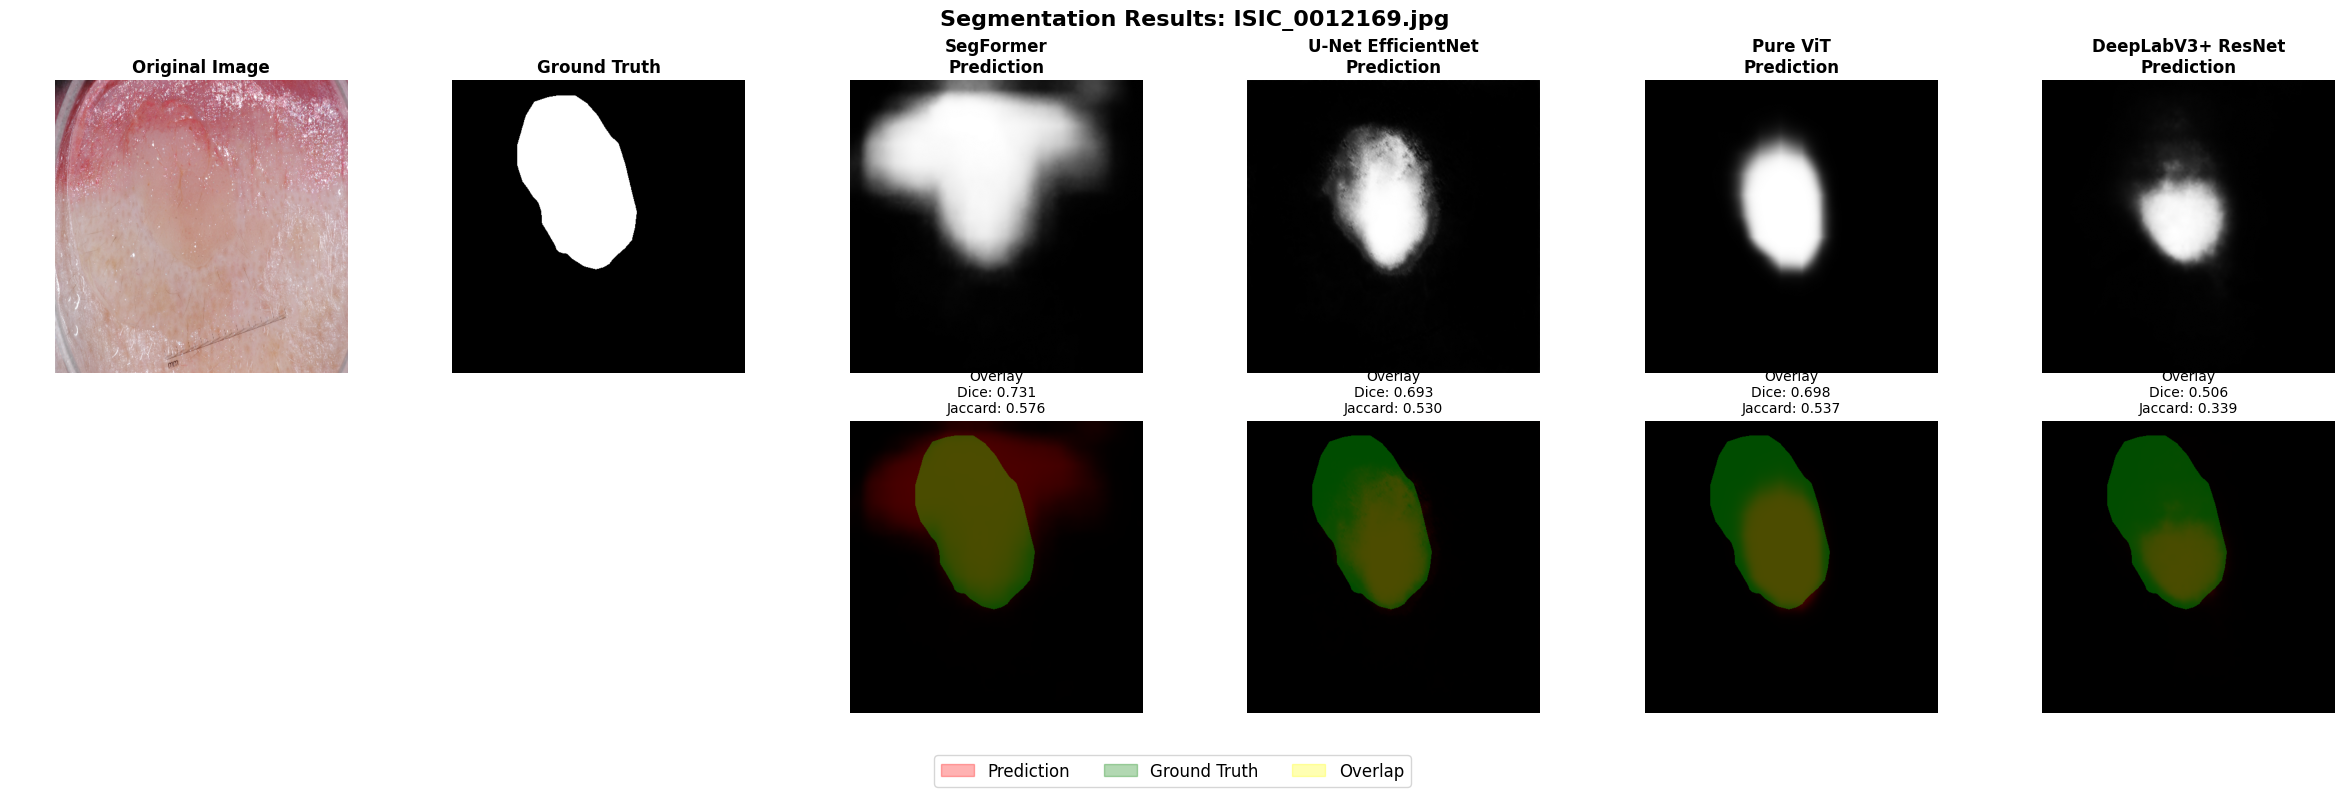


📸 Processing image 2/5: ISIC_0012236.jpg
   SegFormer            - Dice: 0.971, Jaccard: 0.943
   U-Net EfficientNet   - Dice: 0.957, Jaccard: 0.918
   Pure ViT             - Dice: 0.941, Jaccard: 0.888
   DeepLabV3+ ResNet    - Dice: 0.966, Jaccard: 0.935


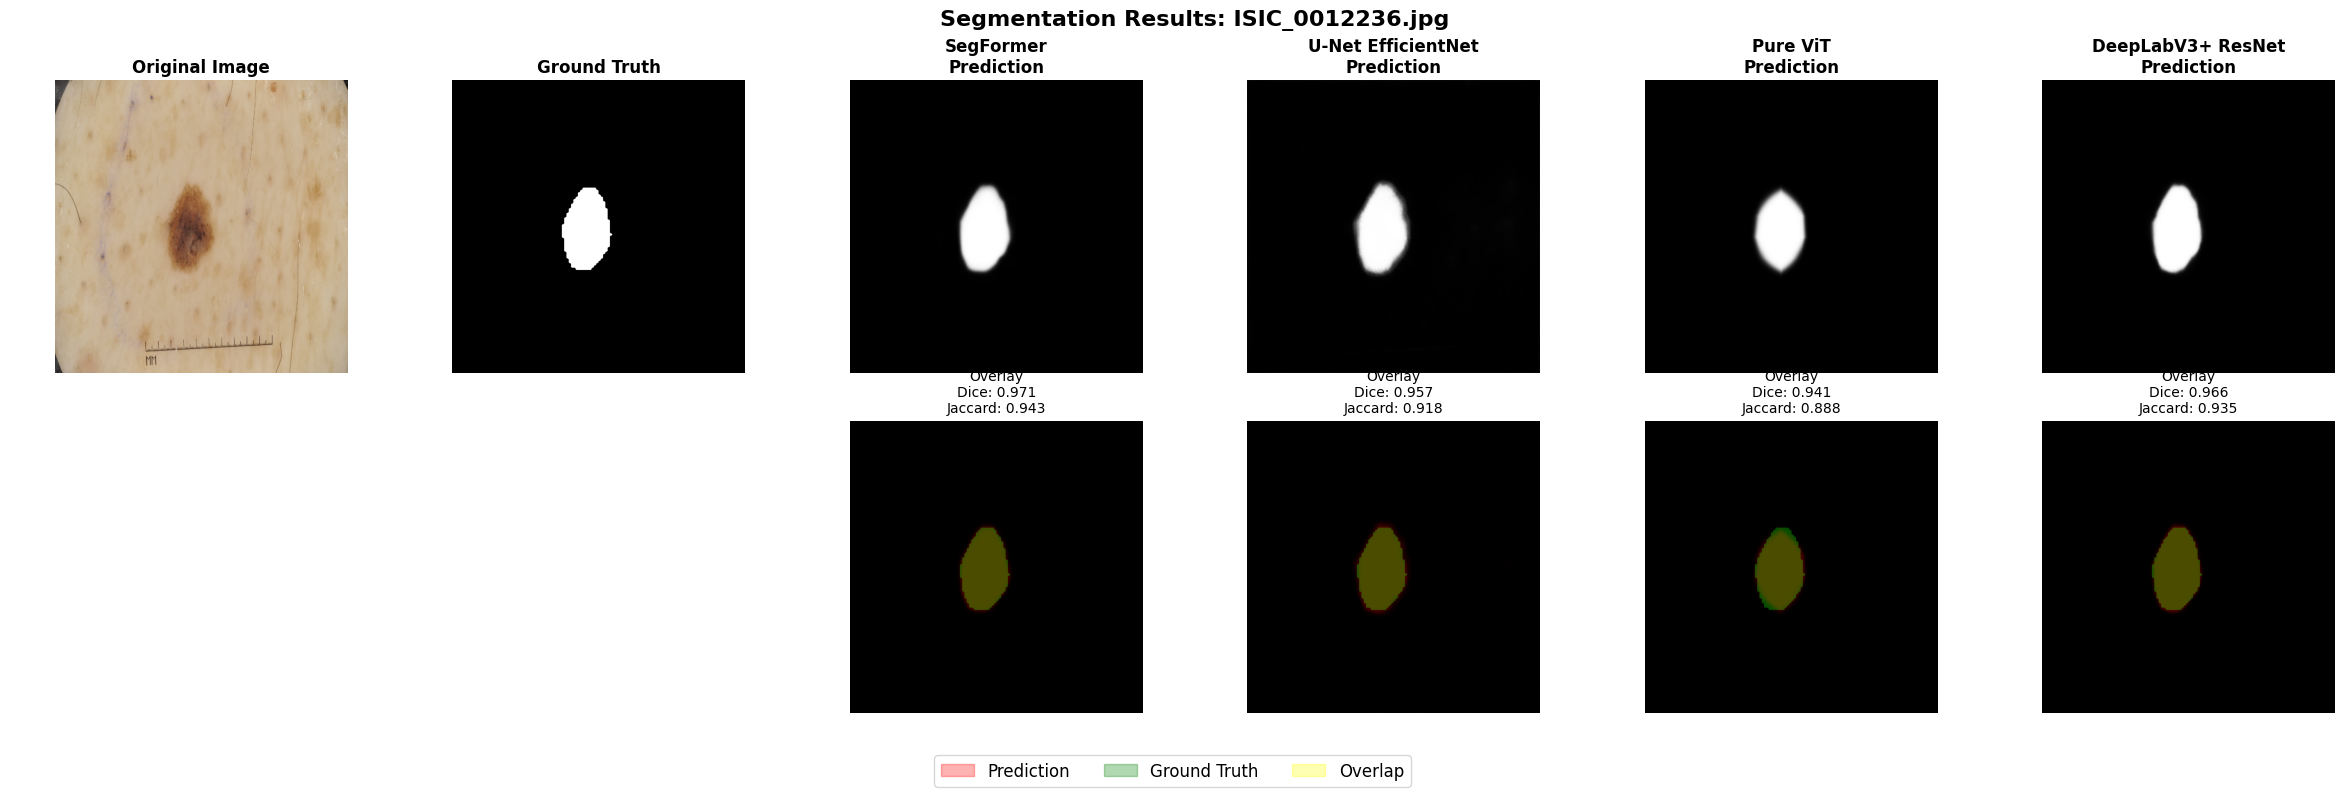


📸 Processing image 3/5: ISIC_0012292.jpg
   SegFormer            - Dice: 0.904, Jaccard: 0.825
   U-Net EfficientNet   - Dice: 0.906, Jaccard: 0.828
   Pure ViT             - Dice: 0.750, Jaccard: 0.600
   DeepLabV3+ ResNet    - Dice: 0.950, Jaccard: 0.905


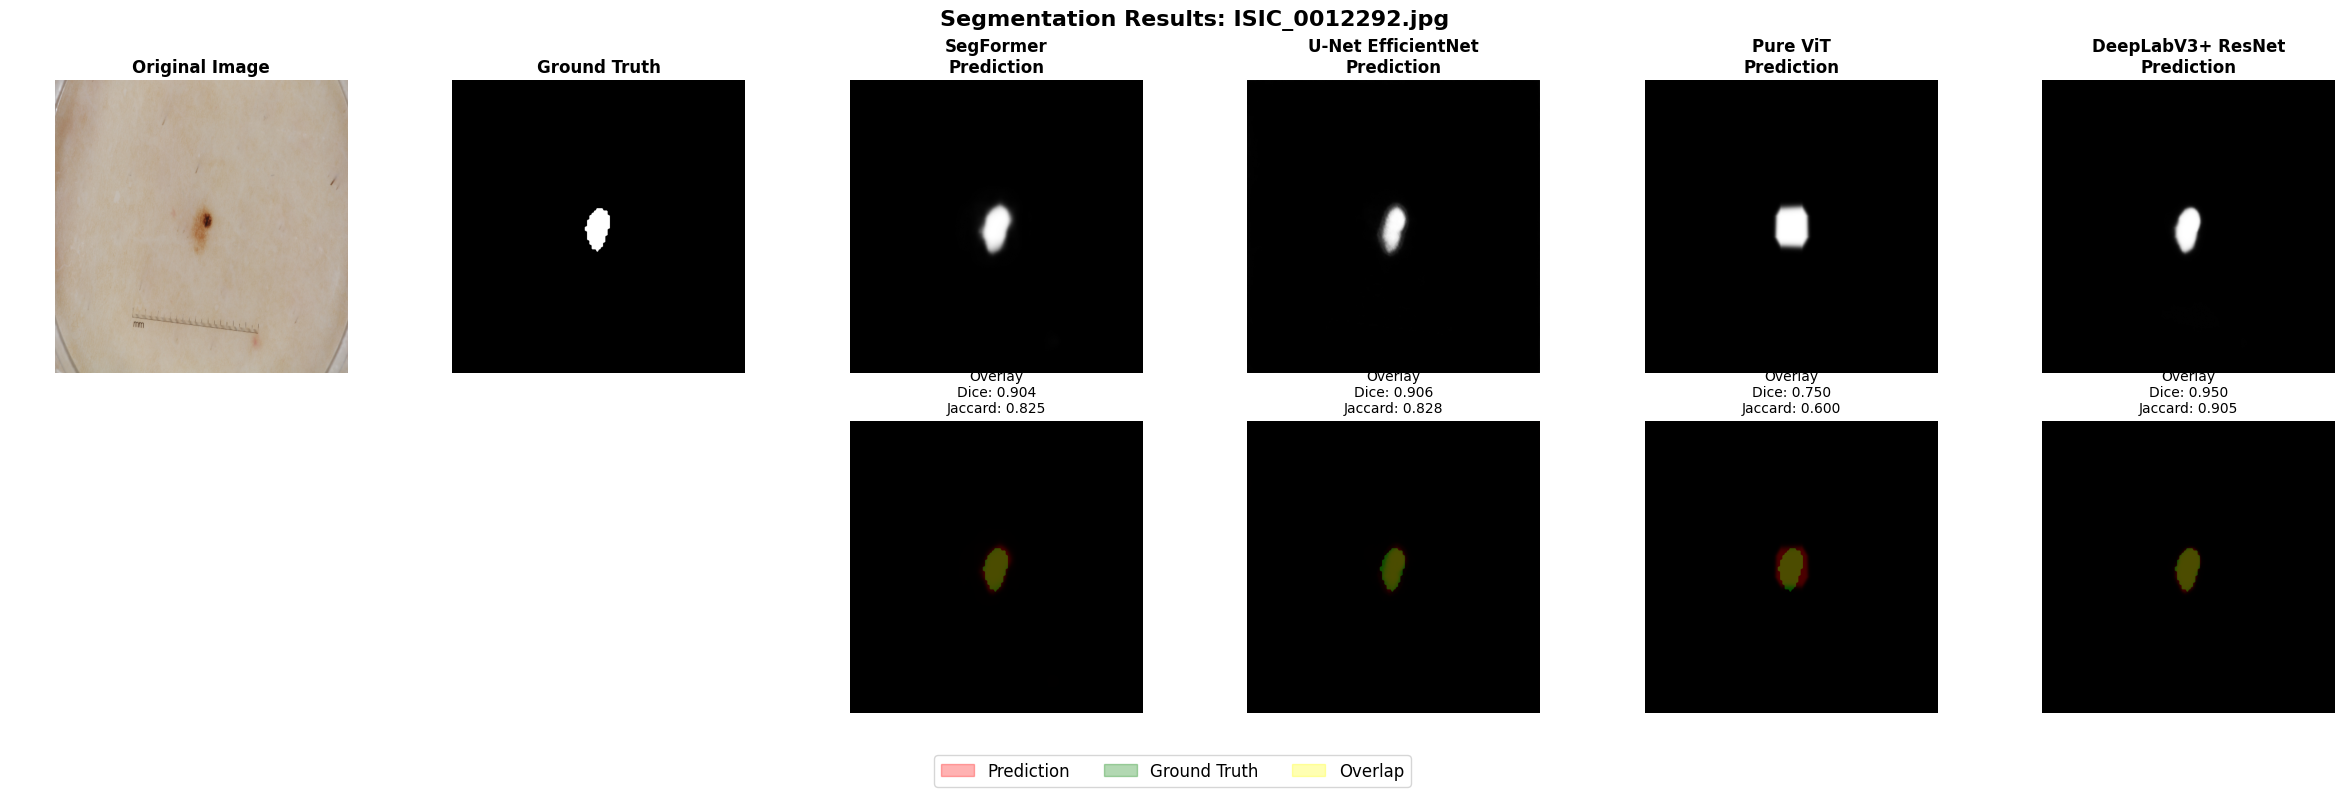


📸 Processing image 4/5: ISIC_0012302.jpg
   SegFormer            - Dice: 0.965, Jaccard: 0.932
   U-Net EfficientNet   - Dice: 0.946, Jaccard: 0.898
   Pure ViT             - Dice: 0.901, Jaccard: 0.820
   DeepLabV3+ ResNet    - Dice: 0.953, Jaccard: 0.911


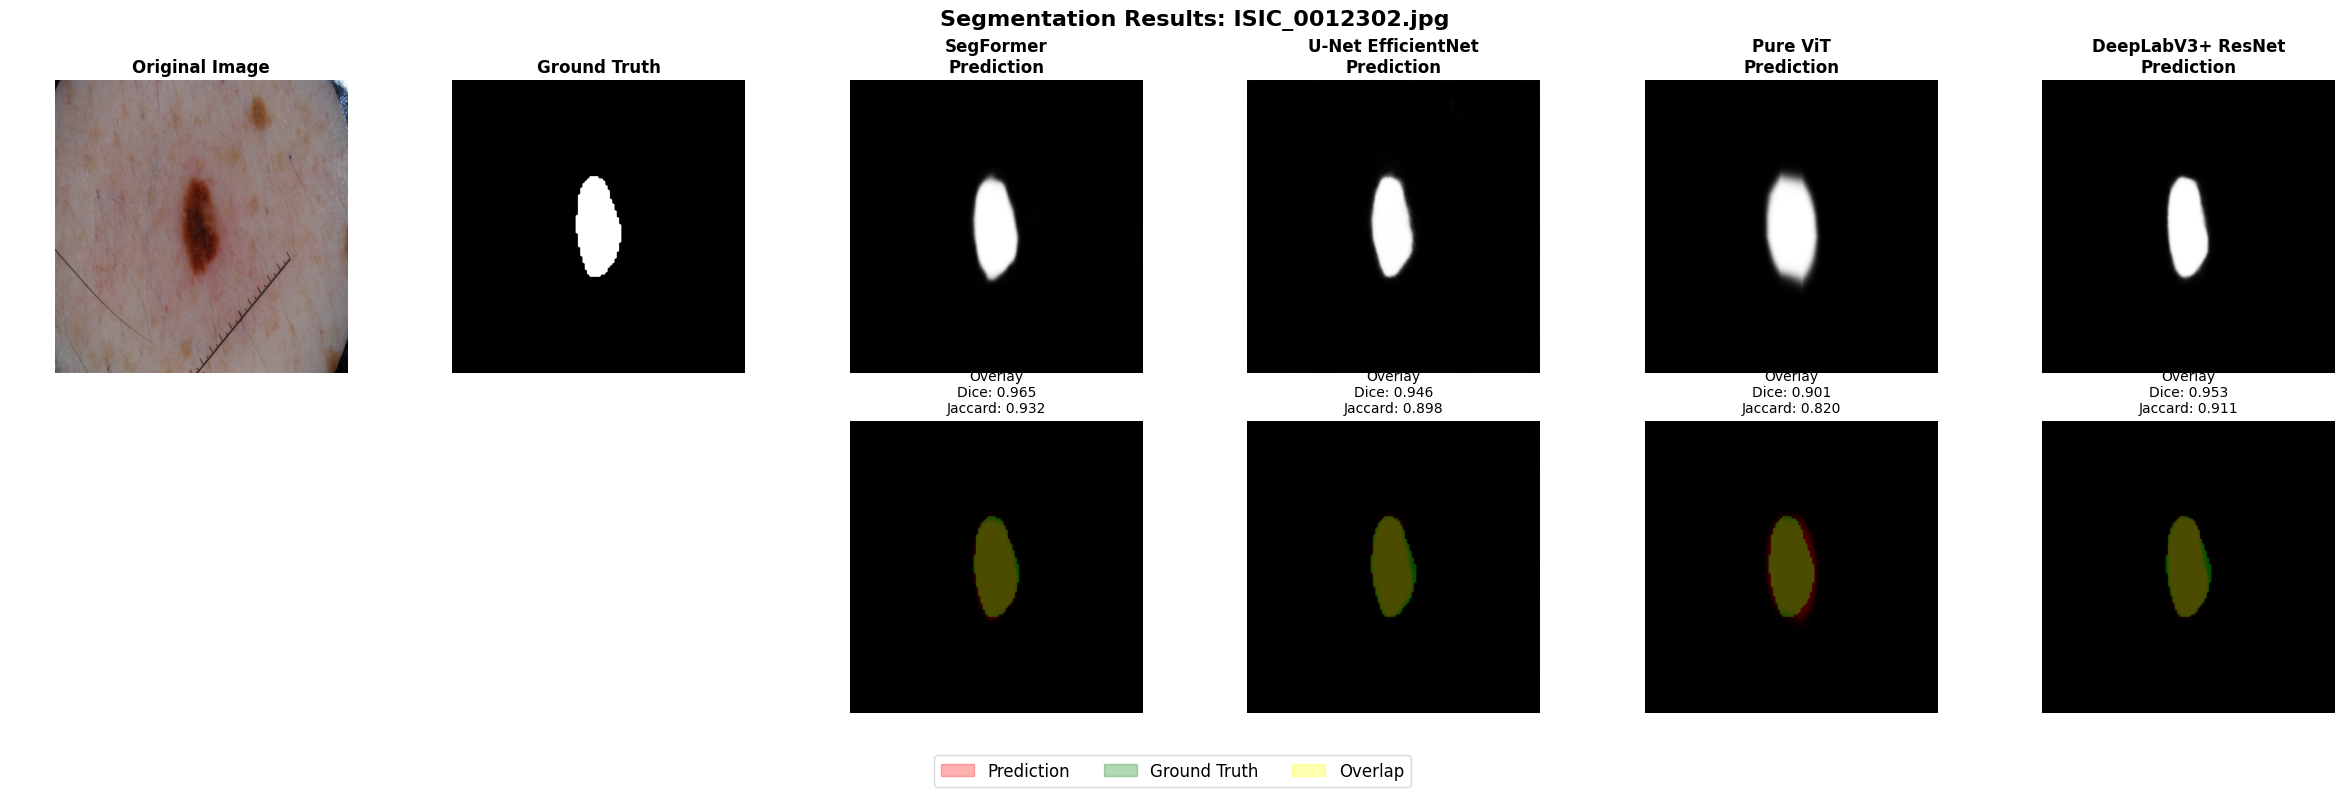


📸 Processing image 5/5: ISIC_0012337.jpg
   SegFormer            - Dice: 0.904, Jaccard: 0.825
   U-Net EfficientNet   - Dice: 0.955, Jaccard: 0.913
   Pure ViT             - Dice: 0.879, Jaccard: 0.784
   DeepLabV3+ ResNet    - Dice: 0.901, Jaccard: 0.819


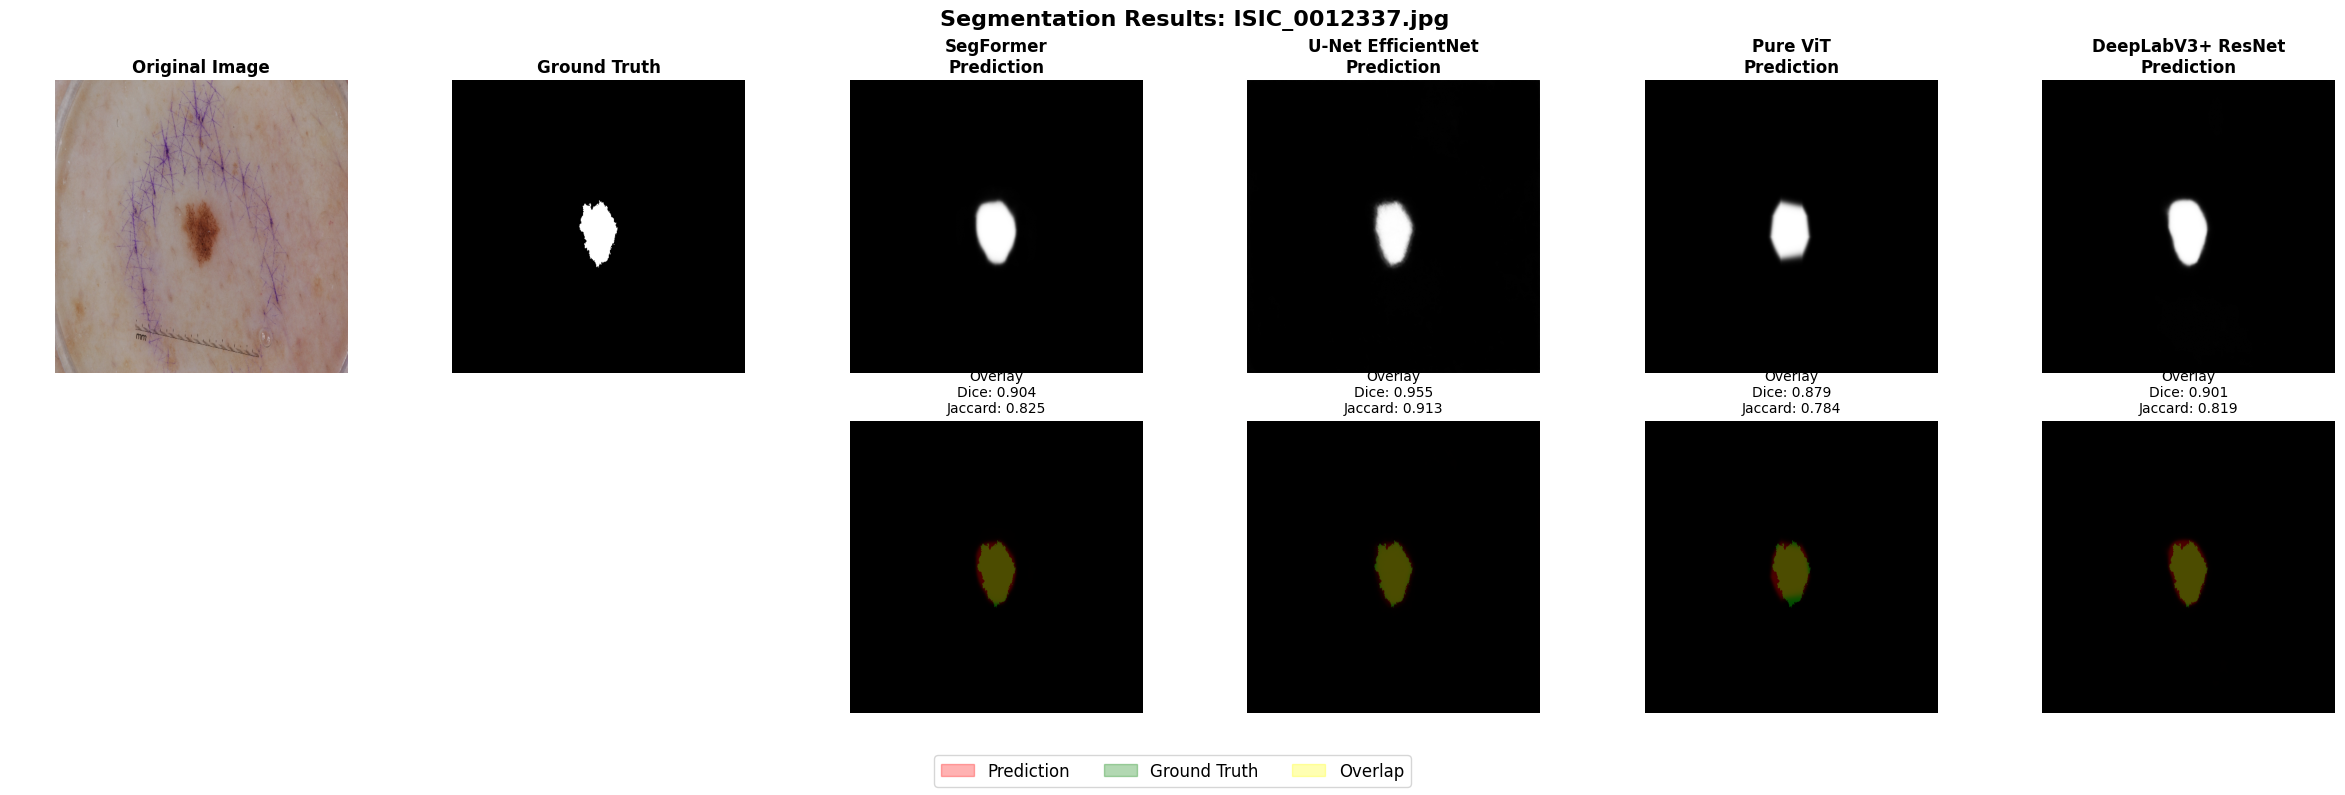


✅ Individual image testing completed!


In [10]:
# Main testing pipeline
if loaded_models and selected_data_dir:
    print("🚀 Starting model evaluation...")
    print("=" * 60)
    
    # Create dataset
    try:
        test_dataset = ISICDataset(
            images_dir=str(selected_data_dir / 'images'),
            masks_dir=str(selected_data_dir / 'ground_truth'),
            transform=test_transform,
            target_size=(512, 512)
        )
        
        if len(test_dataset) == 0:
            print("❌ No test images found!")
        else:
            print(f"\n📊 Dataset loaded successfully with {len(test_dataset)} images")
            
            # Test on a subset of images (to avoid overwhelming output)
            max_test_images = min(5, len(test_dataset))
            print(f"🔍 Testing on {max_test_images} sample images...\n")
            
            # Store all results for summary
            all_metrics = defaultdict(list)
            
            for i in range(max_test_images):
                try:
                    # Load test sample
                    image, true_mask, image_name = test_dataset[i]
                    
                    print(f"📸 Processing image {i+1}/{max_test_images}: {image_name}")
                    
                    # Convert tensors to numpy for visualization
                    image_np = image.permute(1, 2, 0).numpy()
                    # Denormalize image for visualization
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    image_np = image_np * std + mean
                    image_np = np.clip(image_np, 0, 1)
                    
                    true_mask_np = true_mask.squeeze(0).numpy()
                    
                    # Get predictions from all models
                    predictions = {}
                    current_metrics = {}
                    
                    for model_key, model in loaded_models.items():
                        try:
                            # Get prediction
                            pred_mask = predict_single_image(model, image, device)
                            predictions[model_key] = pred_mask
                            
                            # Calculate metrics
                            metrics = calculate_metrics(pred_mask, true_mask_np)
                            current_metrics[model_key] = metrics
                            
                            # Store for summary
                            for metric_name, value in metrics.items():
                                all_metrics[f"{model_key}_{metric_name}"].append(value)
                            
                            # Print metrics
                            config = MODEL_CONFIGS[model_key]
                            print(f"   {config['name']:20} - Dice: {metrics['dice']:.3f}, Jaccard: {metrics['jaccard']:.3f}")
                            
                        except Exception as e:
                            print(f"   ❌ Error with {model_key}: {str(e)}")
                    
                    # Visualize results
                    if predictions:
                        visualize_predictions(
                            image_np, true_mask_np, predictions, 
                            current_metrics, image_name
                        )
                    
                    print()
                    
                except Exception as e:
                    print(f"   ❌ Error processing image {i+1}: {str(e)}")
                    continue
            
            print("✅ Individual image testing completed!")
            
    except Exception as e:
        print(f"❌ Error creating dataset: {str(e)}")
        
else:
    print("⚠️  Cannot run testing:")
    if not loaded_models:
        print("   - No models loaded successfully")
    if not selected_data_dir:
        print("   - No test data directory found")

## 📊 Performance Comparison and Summary

📊 PERFORMANCE SUMMARY

📋 Average Performance Metrics:
--------------------------------------------------------------------------------
Model                Params     Dice     Jaccard  Accuracy Sens.    Spec.   
--------------------------------------------------------------------------------
SegFormer            3.7M       0.895    0.820    0.975    0.972    0.974   
U-Net EfficientNet   5.3M       0.891    0.817    0.982    0.852    0.999   
Pure ViT             5M         0.834    0.726    0.980    0.864    0.996   
DeepLabV3+ ResNet    39.6M      0.855    0.782    0.975    0.845    0.999   
--------------------------------------------------------------------------------

🏆 Best Performance:
   Dice Score: SegFormer (0.895)
   Jaccard Index: SegFormer (0.820)


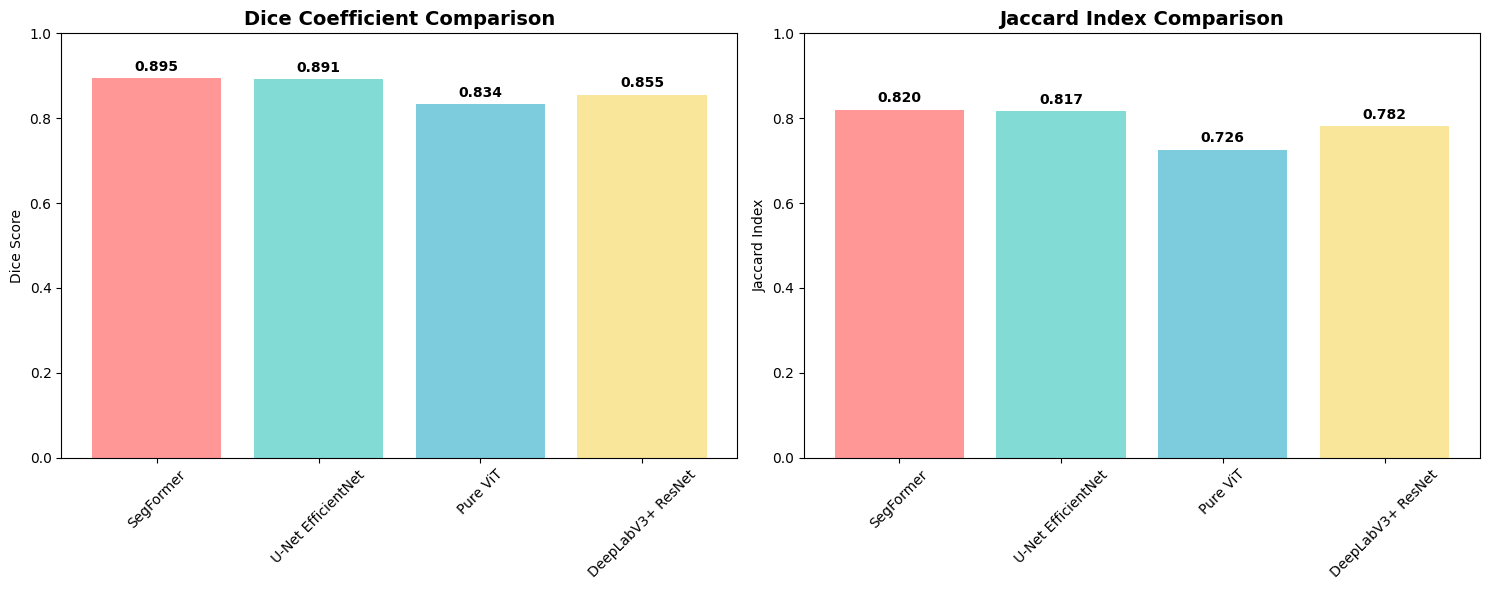


💾 Results saved to: model_evaluation_results.json


In [11]:
# Performance comparison
if loaded_models and 'all_metrics' in locals() and all_metrics:
    print("📊 PERFORMANCE SUMMARY")
    print("=" * 60)
    
    # Calculate average metrics for each model
    summary_data = []
    
    for model_key in loaded_models.keys():
        config = MODEL_CONFIGS[model_key]
        
        # Calculate averages
        dice_scores = all_metrics.get(f"{model_key}_dice", [0])
        jaccard_scores = all_metrics.get(f"{model_key}_jaccard", [0])
        accuracy_scores = all_metrics.get(f"{model_key}_accuracy", [0])
        sensitivity_scores = all_metrics.get(f"{model_key}_sensitivity", [0])
        specificity_scores = all_metrics.get(f"{model_key}_specificity", [0])
        
        avg_dice = np.mean(dice_scores) if dice_scores else 0
        avg_jaccard = np.mean(jaccard_scores) if jaccard_scores else 0
        avg_accuracy = np.mean(accuracy_scores) if accuracy_scores else 0
        avg_sensitivity = np.mean(sensitivity_scores) if sensitivity_scores else 0
        avg_specificity = np.mean(specificity_scores) if specificity_scores else 0
        
        summary_data.append({
            'Model': config['name'],
            'Parameters': config['params'],
            'Dice': avg_dice,
            'Jaccard': avg_jaccard,
            'Accuracy': avg_accuracy,
            'Sensitivity': avg_sensitivity,
            'Specificity': avg_specificity
        })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Display summary table
    print("\n📋 Average Performance Metrics:")
    print("-" * 80)
    print(f"{'Model':<20} {'Params':<10} {'Dice':<8} {'Jaccard':<8} {'Accuracy':<8} {'Sens.':<8} {'Spec.':<8}")
    print("-" * 80)
    
    for _, row in summary_df.iterrows():
        print(f"{row['Model']:<20} {row['Parameters']:<10} "
              f"{row['Dice']:<8.3f} {row['Jaccard']:<8.3f} {row['Accuracy']:<8.3f} "
              f"{row['Sensitivity']:<8.3f} {row['Specificity']:<8.3f}")
    
    print("-" * 80)
    
    # Find best performing model
    best_dice_idx = summary_df['Dice'].idxmax()
    best_jaccard_idx = summary_df['Jaccard'].idxmax()
    
    print(f"\n🏆 Best Performance:")
    print(f"   Dice Score: {summary_df.loc[best_dice_idx, 'Model']} ({summary_df.loc[best_dice_idx, 'Dice']:.3f})")
    print(f"   Jaccard Index: {summary_df.loc[best_jaccard_idx, 'Model']} ({summary_df.loc[best_jaccard_idx, 'Jaccard']:.3f})")
    
    # Create performance comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Dice scores
    colors = [MODEL_CONFIGS[model_key]['color'] for model_key in loaded_models.keys()]
    axes[0].bar(summary_df['Model'], summary_df['Dice'], color=colors, alpha=0.7)
    axes[0].set_title('Dice Coefficient Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Dice Score')
    axes[0].set_ylim(0, 1)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(summary_df['Dice']):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Jaccard scores
    axes[1].bar(summary_df['Model'], summary_df['Jaccard'], color=colors, alpha=0.7)
    axes[1].set_title('Jaccard Index Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Jaccard Index')
    axes[1].set_ylim(0, 1)
    axes[1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(summary_df['Jaccard']):
        axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Save results to JSON
    results_file = 'model_evaluation_results.json'
    results_data = {
        'timestamp': pd.Timestamp.now().isoformat(),
        'summary': summary_df.to_dict('records'),
        'detailed_metrics': dict(all_metrics)
    }
    
    try:
        with open(results_file, 'w') as f:
            json.dump(results_data, f, indent=2, default=str)
        print(f"\n💾 Results saved to: {results_file}")
    except Exception as e:
        print(f"⚠️  Could not save results: {e}")
    
else:
    print("⚠️  No performance data available for comparison")
    print("   Make sure models were loaded and tested successfully")

## 🎯 Conclusion and Next Steps

### 📋 What This Notebook Accomplished:
- ✅ **Model Loading**: Successfully loaded trained models from checkpoints
- ✅ **Data Processing**: Handled test data with proper preprocessing
- ✅ **Inference**: Generated predictions from all available models
- ✅ **Evaluation**: Calculated comprehensive metrics (Dice, Jaccard, Accuracy, etc.)
- ✅ **Visualization**: Created side-by-side comparisons of predictions
- ✅ **Performance Analysis**: Compared models and identified best performers

### 🚀 Next Steps:
1. **Model Selection**: Choose the best performing model for your use case
2. **Hyperparameter Tuning**: Fine-tune the selected model if needed
3. **Deployment**: Prepare the model for production deployment
4. **Further Testing**: Test on additional datasets or edge cases
5. **Ensemble Methods**: Consider combining multiple models for better performance

### 📊 Model Recommendations:
- **For Speed**: Choose the model with fewer parameters and good performance
- **For Accuracy**: Choose the model with highest Dice/Jaccard scores
- **For Balance**: Consider the trade-off between speed and accuracy

### 🔧 Troubleshooting:
If you encounter issues:
1. Check that all required packages are installed
2. Verify model checkpoint files exist and are not corrupted
3. Ensure test data is in the correct format and location
4. Check GPU memory if using CUDA

---
**Note**: This notebook is designed for research and educational purposes. For medical applications, please consult with domain experts and follow appropriate validation procedures.